# Kernel Functions Profiling

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%matplotlib inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# RTApp configurator for generation of PERIODIC tasks
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

# Target Configuration

In [3]:
# Setup target configuration
my_conf = {

    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },  

    # Folder where all the results will be collected
    "results_dir" : "TraceAnalysis_FunctionsProfiling",

    # Define devlib modules to load
    "exclude_modules" : [ 'hwmon' ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
        "functions" : [
            "pick_next_task_fair",
            "select_task_rq_fair",
            "enqueue_task_fair",
            "update_curr_fair",
            "dequeue_task_fair",
            
            # for tests
            "scheduler_timeout",
            "tick_sched_timer",
            "tick_sched_do_timer",
            "schedtune_cpu_boost",
            "schedtune_task_boost",
            "schedtune_prefer_idle",
            "schedtune_enqueue_task",
            "schedtune_dequeue_task",
        ],
        
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'rt-app' ],
    

}

In [4]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

09:24:40  INFO    : Using base path: /home/lisa/lisa-github
09:24:40  INFO    : Loading custom (inline) target configuration
09:24:40  INFO    : External tools using:
09:24:40  INFO    :    ANDROID_HOME: /home/lisa/android-sdk
09:24:40  INFO    :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
09:24:40  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
09:24:40  INFO    : Connecting Android target [0123456789ABCDEF]
09:24:40  INFO    : Connection settings:
09:24:40  INFO    :    {'device': '0123456789ABCDEF'}
09:24:40  INFO    : Initializing target workdir:
09:24:40  INFO    :    /data/local/tmp/devlib-target
09:24:42  INFO    : Attempting to read energy model from target
09:24:44  INFO    : Topology:
09:24:44  INFO    :    [[0, 1, 2, 3], [4, 5, 6, 7]]
09:24:44  INFO    : Loading default EM:
09:24:44  INFO    :    /home/lisa/lisa-github/libs/utils/platforms/hikey960.json
09:24:44  WARNING : Function [scheduler_timeout] not available for profiling
09:24:44  WARNING 

# Workload Execution and Functions Profiling Data Collection

In [5]:
def experiment(te):

    # Create and RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  60,
                        end_pct   =  20,
                        delta_pct =   5,
                        time_s    =   0.5).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Collect and keep track of the Kernel Functions performance data
    stats_file = os.path.join(te.res_dir, 'trace.stats')
    te.ftrace.get_stats(stats_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [6]:
experiment(te)

09:24:45  INFO    : Setup new workload ramp
09:24:45  INFO    : Workload duration defined by longest task
09:24:45  INFO    : Default policy: SCHED_OTHER
09:24:45  INFO    : ------------------------
09:24:45  INFO    : task [ramp], sched: using default policy
09:24:45  INFO    :  | loops count: 1
09:24:45  INFO    : + phase_000001: duration 0.500000 [s] (5 loops)
09:24:45  INFO    : |  period   100000 [us], duty_cycle  60 %
09:24:45  INFO    : |  run_time  60000 [us], sleep_time  40000 [us]
09:24:45  INFO    : + phase_000002: duration 0.500000 [s] (5 loops)
09:24:45  INFO    : |  period   100000 [us], duty_cycle  55 %
09:24:45  INFO    : |  run_time  55000 [us], sleep_time  45000 [us]
09:24:45  INFO    : + phase_000003: duration 0.500000 [s] (5 loops)
09:24:45  INFO    : |  period   100000 [us], duty_cycle  50 %
09:24:45  INFO    : |  run_time  50000 [us], sleep_time  50000 [us]
09:24:45  INFO    : + phase_000004: duration 0.500000 [s] (5 loops)
09:24:45  INFO    : |  period   100000 [

09:24:48  INFO    : Workload execution START:
09:24:48  INFO    :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/ramp_00.json 2>&1


# Parse Trace and Profiling Data

In [7]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

09:24:54  INFO    : Content of the output folder /home/lisa/lisa-github/results/TraceAnalysis_FunctionsProfiling


/home/lisa/lisa-github/results/TraceAnalysis_FunctionsProfiling
|-- output.log
|-- platform.json
|-- ramp_00.json
|-- rt-app-ramp-0.log
|-- rt-app-ramp_1-0.log
|-- rt-app-ramp_1-2.log
|-- rt-app-ramp_2-3.log
|-- trace.dat
`-- trace.stats

0 directories, 9 files


In [8]:
with open(os.path.join(res_dir, 'platform.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

09:24:55  INFO    : LITTLE cluster max capacity: 402


In [9]:
trace = Trace(platform, res_dir, events=[])

09:24:55  INFO    : Trace contains only functions stats


In [14]:
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

NameError: name 'trappy' is not defined

# Report Functions Profiling Data

In [10]:
# Get the DataFrame for the specified list of kernel functions
df = trace.data_frame.functions_stats(['enqueue_task_fair', 'dequeue_task_fair'])
df

hits     avg       time     s_2
0 dequeue_task_fair  1143   8.480   9693.745  62.625
  enqueue_task_fair  1233  11.247  13867.690  87.260
1 dequeue_task_fair   126  13.566   1709.373  27.559
  enqueue_task_fair    25  14.979    374.479  58.937
2 dequeue_task_fair   578   8.023   4637.477  14.602
  enqueue_task_fair   562   9.950   5592.193  15.169
3 dequeue_task_fair    89   7.040    626.569  18.755
4 dequeue_task_fair    96   3.634    348.948   7.310
  enqueue_task_fair    83   3.884    322.394  10.925
5 dequeue_task_fair   118   2.961    349.484   5.252
  enqueue_task_fair    27   4.861    131.247   6.990
6 dequeue_task_fair   240   1.985    476.550   1.891
  enqueue_task_fair   203   2.224    451.569   2.785
7 dequeue_task_fair   168   5.887    989.069   8.595
  enqueue_task_fair   170  10.876   1848.955  85.516

In [11]:
# Get the DataFrame for the single specified kernel function
df = trace.data_frame.functions_stats('select_task_rq_fair')
df

,,hits,avg,time,s_2
0,select_task_rq_fair,1233,10.899,13439.070,141.801
1,select_task_rq_fair,24,8.094,194.272,153.865
2,select_task_rq_fair,547,14.018,7668.223,28.302
4,select_task_rq_fair,85,4.417,375.517,36.314
5,select_task_rq_fair,29,4.903,142.190,49.440
6,select_task_rq_fair,177,1.833,324.475,7.925
7,select_task_rq_fair,150,8.812,1321.873,109.342


# Plot Functions Profiling Data

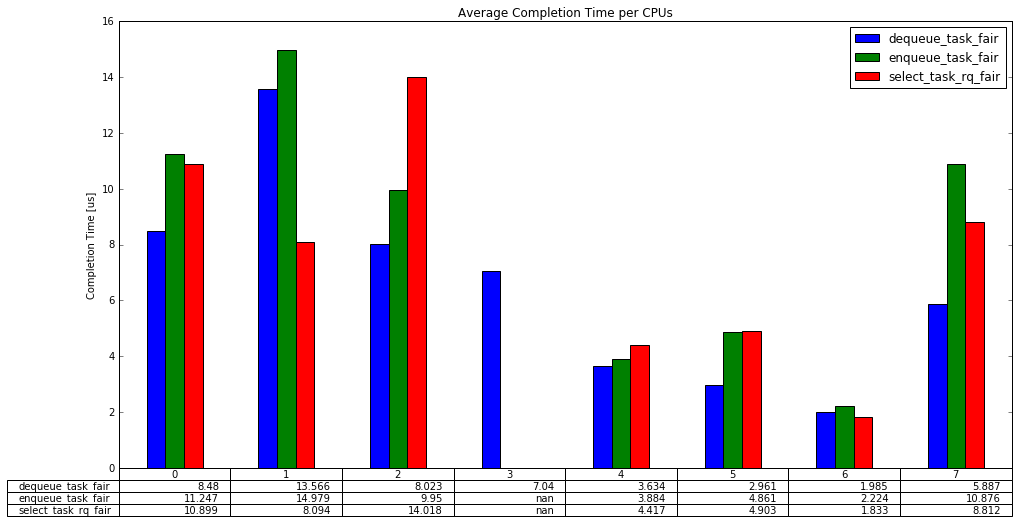

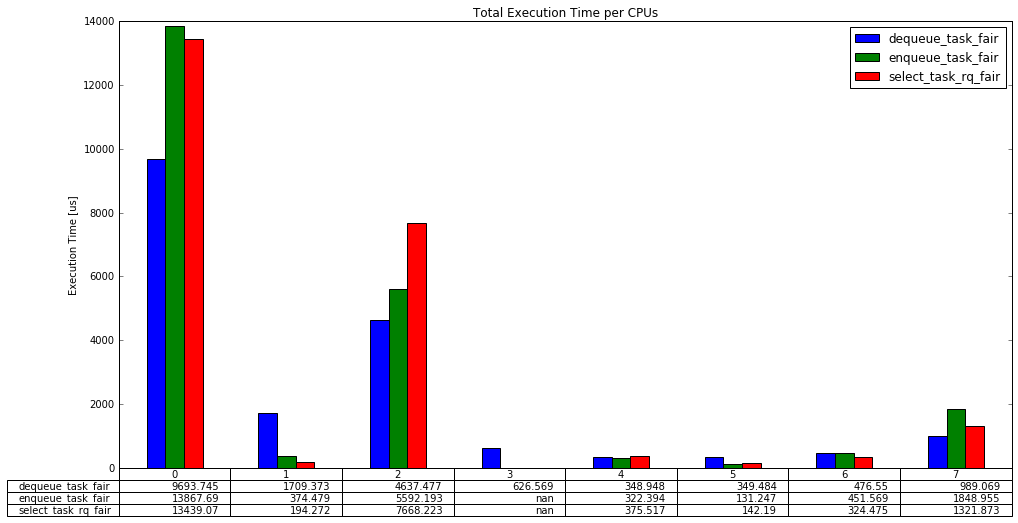

In [12]:
# Plot Average and Total execution time for the specified
# list of kernel functions
trace.analysis.functions.plotProfilingStats(
    functions = [
        'select_task_rq_fair',
        'enqueue_task_fair',
        'dequeue_task_fair'
    ],
    metrics = [
        'avg',
        'time',
    ]
)

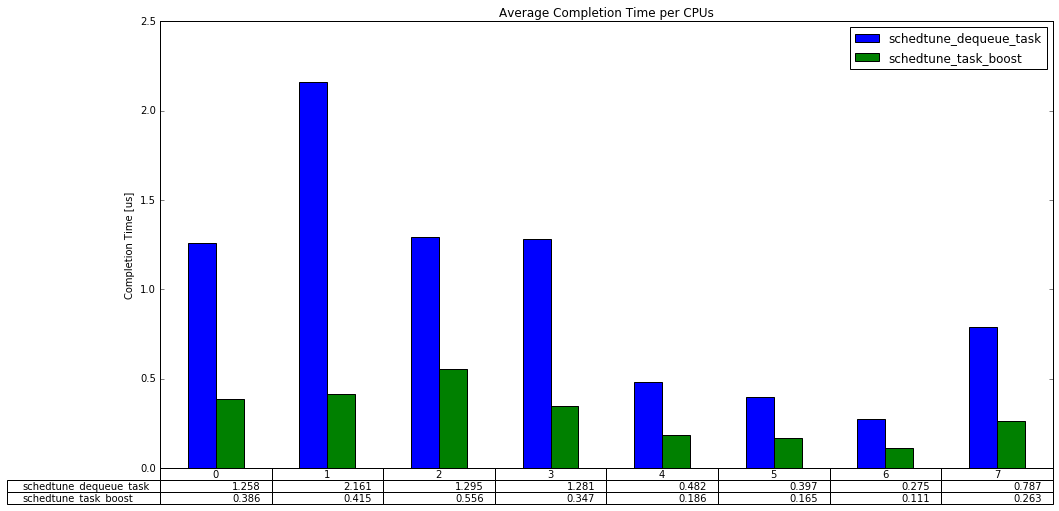

In [13]:
# Plot Average execution time for the single specified kernel function
trace.analysis.functions.plotProfilingStats(
    functions = [
            "scheduler_timeout",
            "schedtune_dequeue_task",
            "schedtune_task_boost",        
                ]
)